
# ***Imports and Setup***

---



---





In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0,ResNet50V2,Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Extract Dataset***

---



---



In [3]:
zip_data = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
zip_data.extractall('/tmp')
zip_data.close()

file_path = '/tmp/utkcropped/utkcropped'


# ***Process Filenames and Create DataFrame***

---



---



In [4]:
age, img_path = [], []

for file in os.listdir(file_path):
    try:

        parts = file.split('_')

        age_val = int(parts[0])
        age.append(age_val)
        img_path.append(file)


    except (IndexError, ValueError) as e:
        print(f"Error processing file: {file}. Error: {e}")


df = pd.DataFrame({'age': age, 'img_path': img_path})

filtered_data = df[(df['age'] >= 10) & (df['age'] <= 90)].reset_index(drop=True)

In [5]:
print(f"min age: {filtered_data['age'].min()}, max age: {filtered_data['age'].max()}")

min age: 10, max age: 90


In [6]:
print(filtered_data.shape)

(20560, 2)


# ***Display an Image with Metadata***

---



---



shape of image: (200, 200)


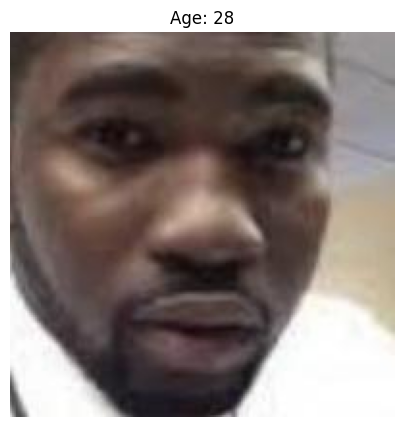

In [ ]:

def show_image(dataframe, index, file_path):

    row = dataframe.iloc[index]
    img_full_path = os.path.join(file_path, row['img_path'])


    image = Image.open(img_full_path)
    print(f"shape of image: {image.size}")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Age: {row['age']}")
    plt.show()

show_image(filtered_data, index=26, file_path=file_path)

# ***Create Data Generators***

---



---



In [19]:
# Define the image size for resizing
IMG_SIZE = (128, 128)

# Function to load and preprocess images in batches with augmentation
def create_data_generator(df, base_path, batch_size=32, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255.0,
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255.0)  # Without augmentation

    # Create the data generator for images and labels
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=base_path,
        x_col='img_path',  # Column in the DataFrame containing image filenames
        y_col='age',  # Column containing the target labels (age)
        target_size=IMG_SIZE,  # Resize images to this size
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' for regression tasks (age prediction)
        shuffle=True
    )

# Split the data into training, validation, and test sets
train_val_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

# Create the data generators
train_generator = create_data_generator(train_data, file_path, batch_size=32, augment=True)
val_generator = create_data_generator(val_data, file_path, batch_size=32, augment=False)
test_generator = create_data_generator(test_data, file_path, batch_size=32, augment=False)
print(f"Training data generator: {train_generator.samples} samples")
print(f"Validation data generator: {val_generator.samples} samples")
print(f"Testing data generator: {test_generator.samples} samples")

Found 13158 validated image filenames.
Found 3290 validated image filenames.
Found 4112 validated image filenames.
Training data generator: 13158 samples
Validation data generator: 3290 samples
Testing data generator: 4112 samples


# ***Build XCEPTION Transfer Learning Model***

---



---





In [ ]:
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model_xception.layers:
        layer.trainable = False
# Add custom layers for regression
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
Dense(units=256, activation='relu', name="Layer_1"),
Dropout(0.5),


output = Dense(1, activation='linear')(x)  # Output layer for regression (age prediction)

# Create the model
model_xception = Model(inputs=base_model_xception.input, outputs=output)


# Compile the model
model_xception.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model_xception.summary()




83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

# ***Train the Model***

---



---



In [ ]:
# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


history_xception = model_xception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # You can adjust the number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 483.6192 - mae: 16.7390

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


411/411 ━━━━━━━━━━━━━━━━━━━━ 141s 256ms/step - loss: 483.0055 - mae: 16.7249 - val_loss: 88.9535 - val_mae: 7.1509 - learning_rate: 0.0010
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 132.9406 - mae: 8.7118 - val_loss: 90.0693 - val_mae: 7.0980 - learning_rate: 0.0010
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 106s 216ms/step - loss: 89.0197 - mae: 7.1263 - val_loss: 150.4888 - val_mae: 10.0036 - learning_rate: 0.0010
Epoch 4/10
  1/411 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - loss: 94.8003 - mae: 7.3765
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 94.8003 - mae: 7.3765 - val_loss: 140.1926 - val_mae: 9.5829 - learning_rate: 0.0010
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 90s 215ms/step - loss: 71.4816 - mae: 6.3645 - val_loss: 62.8577 - val_mae: 5.9289 - learning_rate: 5.0000e-04
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 52.4184 - mae: 5.9939 - val_loss: 63.5159 - val_mae: 5.94

# ***Plot Training and Validation Loss***

---



---



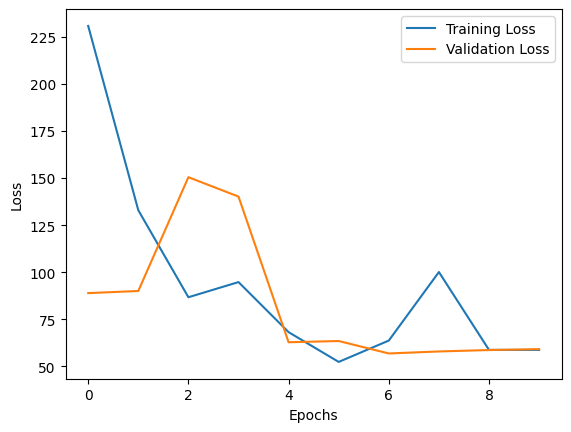

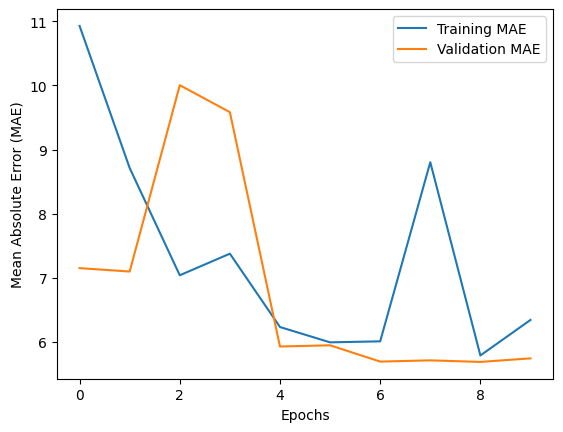

In [ ]:
# Function to plot training and validation loss
# Plot training & validation loss
plt.plot(history_xception.history['loss'], label='Training Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(history_xception.history['mae'], label='Training MAE')
plt.plot(history_xception.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()


# ***Evaluate the Model on Test Set***

---



---




In [ ]:
test_loss_xception, test_mae_xception = model_xception.evaluate(test_generator)
print(f"Test Loss: {test_loss_xception}, Test MAE: {test_mae_xception}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 59.3056 - mae: 5.7210
Test Loss: 58.57347869873047, Test MAE: 5.7008867263793945


In [14]:
def load_and_preprocess_image(img_path, img_size=(128, 128)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [15]:
def predict_age(img_path,predicted_age):
  img = load_img(img_path)  # Load the image for plotting
  plt.figure(figsize=(6, 6))

  # Plot the image
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title("Input Image")
  plt.axis('off')  # Turn off axes for better visualization

  # Plot the predicted age
  plt.subplot(1, 2, 2)
  plt.bar(["Predicted Age"], [int(predicted_age[0][0])], color='blue')
  plt.title(f"Predicted Age: {int(predicted_age[0][0]):.2f}")
  plt.ylim(0, 100)  # Set the y-axis limit for age predictions

  # Show the plots
  plt.tight_layout()
  plt.show()

In [16]:
img_path_shehab = '/content/shehab.jpg'  # Replace with your image path
processed_image_shehab = load_and_preprocess_image(img_path_shehab)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


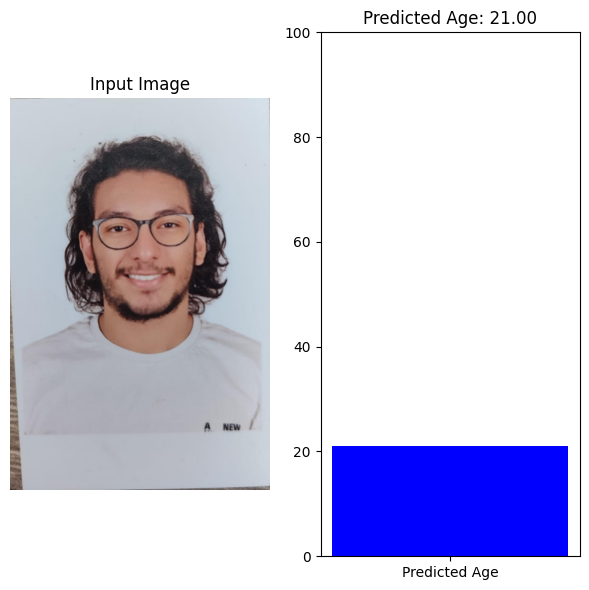

In [ ]:
predicted_age_shehab_xception = model_xception.predict(processed_image_shehab)
predict_age(img_path_shehab,predicted_age_shehab_xception)

In [ ]:
img_path_amr = '/content/amr.jpeg'  # Replace with your image path
processed_image_amr = load_and_preprocess_image(img_path_amr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


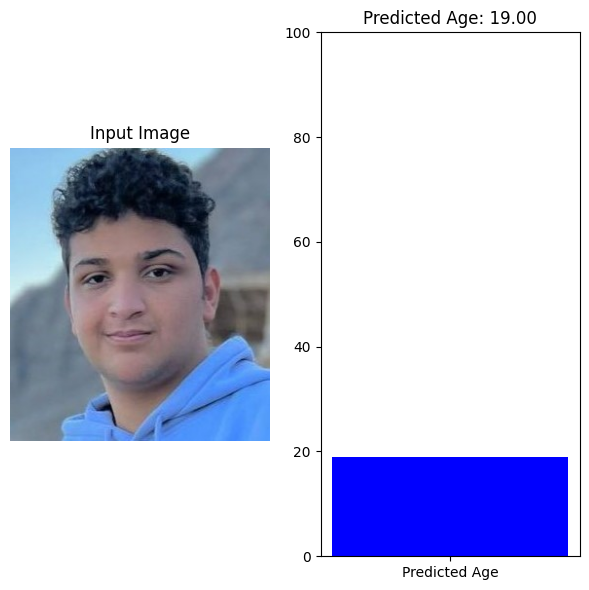

In [ ]:

predicted_age_amr_xception = model_xception.predict(processed_image_amr)
predict_age(img_path_amr,predicted_age_amr_xception)

In [ ]:
img_path_nada = '/content/nada.jpg'  # Replace with your image path
processed_image_nada = load_and_preprocess_image(img_path_nada)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


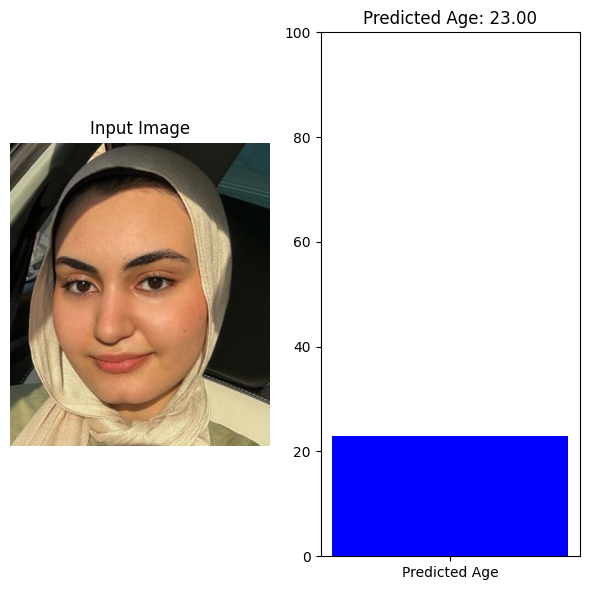

In [ ]:

predicted_age_nada_xception = model_xception.predict(processed_image_nada)
predict_age(img_path_nada,predicted_age_nada_xception)

In [ ]:
img_path_malak = '/content/malak.jpg'  # Replace with your image path
processed_image_malak = load_and_preprocess_image(img_path_malak)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


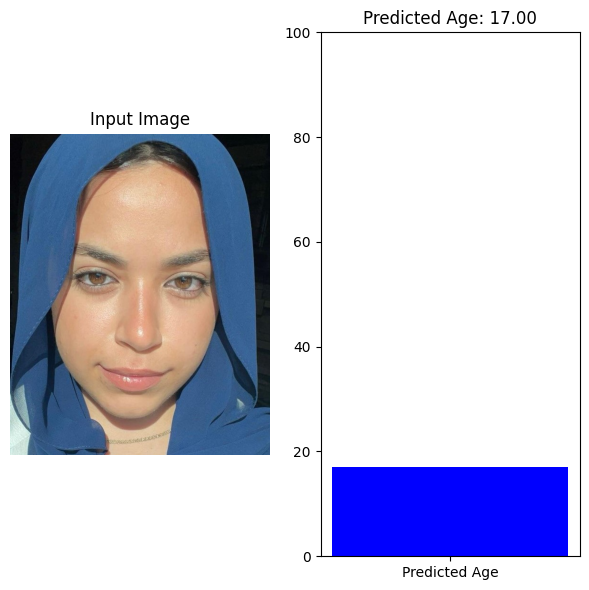

In [ ]:

predicted_age_malak_xception = model_xception.predict(processed_image_malak)
predict_age(img_path_malak,predicted_age_malak_xception)

# ***Build RESNET50 Transfer Learning Model***

---



---





In [21]:
# Define the image size for resizing
IMG_SIZE = (224, 224)  # we use 224 for resnet50

# Function to load and preprocess images in batches with augmentation
def create_data_generator_resnet(df, base_path, batch_size=32, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255.0,
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255.0)  # Without augmentation

    # Create the data generator for images and labels
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=base_path,
        x_col='img_path',
        y_col='age',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' for regression tasks (age prediction)
        shuffle=True
    )

# Split the data into training, validation, and test sets
train_val_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

# Create the data generators
train_generator = create_data_generator_resnet(train_data, file_path, batch_size=32, augment=True)
val_generator = create_data_generator_resnet(val_data, file_path, batch_size=32, augment=False)
test_generator = create_data_generator_resnet(test_data, file_path, batch_size=32, augment=False)
print(f"Training data generator: {train_generator.samples} samples")
print(f"Validation data generator: {val_generator.samples} samples")
print(f"Testing data generator: {test_generator.samples} samples")

base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_ResNet50.layers:
        layer.trainable = False
# Add custom layers for regression
x = base_model_ResNet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.65)(x)  # Add dropout to prevent overfitting
output = Dense(1, activation='linear')(x)  # Output layer for regression (age prediction)

# Create the model
model_ResNet50 = Model(inputs=base_model_ResNet50.input, outputs=output)

# Compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

model_ResNet50.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# ***Train the Model***

---



---



In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,min_lr=1e-6)

# Train the model
history_ResNet50 = model_ResNet50.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  # You can adjust the number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 299s 565ms/step - loss: 318.9784 - mae: 13.0232 - val_loss: 315.7832 - val_mae: 12.8461 - learning_rate: 5.0000e-04
Epoch 2/20
  1/411 ━━━━━━━━━━━━━━━━━━━━ 1:52 274ms/step - loss: 195.0365 - mae: 11.7401

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 195.0365 - mae: 11.7401 - val_loss: 511.1469 - val_mae: 18.5999 - learning_rate: 5.0000e-04
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 225s 541ms/step - loss: 167.7962 - mae: 9.7265 - val_loss: 267.1059 - val_mae: 11.4975 - learning_rate: 5.0000e-04
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 361.5216 - mae: 15.5124 - val_loss: 240.2126 - val_mae: 9.7213 - learning_rate: 5.0000e-04
Epoch 5/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 267s 555ms/step - loss: 162.2605 - mae: 9.6372 - val_loss: 115.8017 - val_mae: 7.7721 - learning_rate: 5.0000e-04
Epoch 6/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 153.0381 - mae: 7.8986 - val_loss: 26.5830 - val_mae: 4.3170 - learning_rate: 5.0000e-04
Epoch 7/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 250s 551ms/step - loss: 147.9651 - mae: 9.2512 - val_loss: 127.4154 - val_mae: 8.4477 - learning_rate: 5.0000e-04
Epoch 8/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step - loss: 95.4355 - mae: 7.5764 - val_lo

# ***Evaluate the Model on Test Set***

---



---



In [23]:
test_loss_ResNet50, test_mae_ResNet50 = model_ResNet50.evaluate(test_generator)
print(f"Test Loss (ResNet50): {test_loss_ResNet50}, Test MAE (ResNet50): {test_mae_ResNet50}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 109.3357 - mae: 7.6581
Test Loss (ResNet50): 108.23889923095703, Test MAE (ResNet50): 7.613358974456787


# ***Plot Training and Validation Loss***

---



---





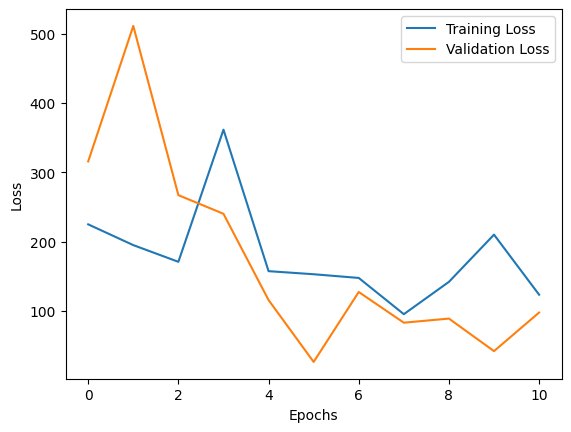

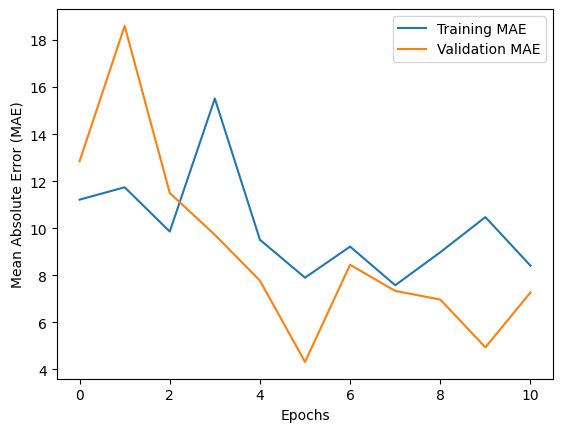

In [24]:
# Function to plot training and validation loss
# Plot training & validation loss
plt.plot(history_ResNet50.history['loss'], label='Training Loss')
plt.plot(history_ResNet50.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(history_ResNet50.history['mae'], label='Training MAE')
plt.plot(history_ResNet50.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()


# ***Build Costumized Model (1)***

---



---





In [8]:
# Define the model
model_1 = Sequential([
    # First Convolutional Layer
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3), name="Conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="Max_Pool_1"),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name="Conv_2"),
    MaxPooling2D(pool_size=(2, 2), name="Max_Pool_2"),

    # Second Convolutional Layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="Conv_3"),
    MaxPooling2D(pool_size=(2, 2), name="Max_Pool_3"),


    # Flatten Layer
    Flatten(),

    # Fully Connected Layers\
    Dense(units=256, activation='relu', name="Layer_1"),
    Dropout(0.3),

    Dense(units=256, activation='relu', name="Layer_2"),
    Dropout(0.3),

    Dense(units=128, activation='relu', name="Layer_3"),
    Dropout(0.3),


    # Output Layer (for regression, predicting age)
    Dense(units=1, activation='linear')  # Linear activation for regression tasks
])


# Reduce learning rate when the validation loss plateaus
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    print(f"Epoch {epoch + 1}: Learning Rate is {new_lr}")
    return new_lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau
lr_plateau_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model_1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_2 (MaxPooling2D)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_3 (Conv2D)                      │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_3 (MaxPooling2D)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_1 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,322,017 (16.49 MB)

 Trainable params: 4,322,017 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

# ***Train the Model***

---



---



In [9]:
history_1 = model_1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[lr_scheduler, lr_plateau_scheduler],
    verbose=1
)

Epoch 1: Learning Rate is 0.001
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 79s 165ms/step - loss: 413.8388 - mae: 15.5966 - val_loss: 260.3203 - val_mae: 11.7244 - learning_rate: 0.0010
Epoch 2: Learning Rate is 0.001
Epoch 2/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 72s 158ms/step - loss: 298.0681 - mae: 13.2741 - val_loss: 211.8983 - val_mae: 10.7843 - learning_rate: 0.0010
Epoch 3: Learning Rate is 0.001
Epoch 3/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - loss: 279.0896 - mae: 12.8180 - val_loss: 202.1231 - val_mae: 10.6118 - learning_rate: 0.0010
Epoch 4: Learning Rate is 0.001
Epoch 4/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 63s 152ms/step - loss: 257.6436 - mae: 12.2714 - val_loss: 198.3425 - val_mae: 10.2227 - learning_rate: 0.0010
Epoch 5: Learning Rate is 0.001
Epoch 5/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - loss: 249.6728 - mae: 12.0777 - val_loss: 224.1012 - val_mae: 10.6063 - learning_rate: 0.0010
Epoch 6: Learning Rate is 0.0005
Epoch 6/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 65s 155ms/step - loss: 223.3469 - mae: 11.3459 - val_lo

# ***Evaluate the Model on Test Set***

---



---



In [10]:
test_loss_1, test_mae_1 = model_1.evaluate(test_generator)
print(f"Test Loss: {test_loss_1}")
print(f"Test MAE: {test_mae_1}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 110.9727 - mae: 7.7682
Test Loss: 113.92713165283203
Test MAE: 7.814184665679932


# ***Plot Training and Validation Loss***

---



---






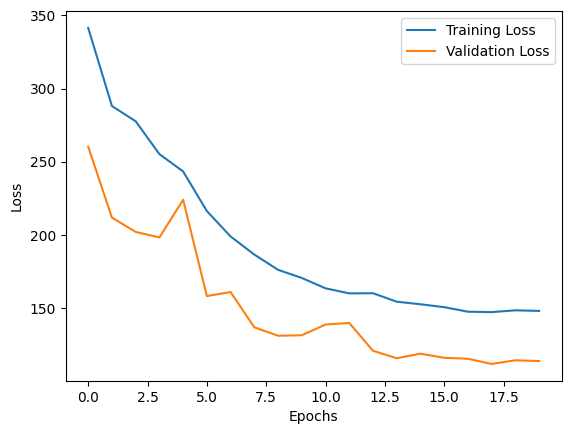

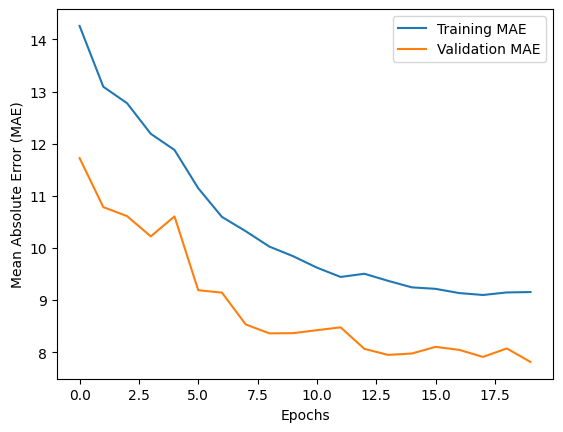

In [11]:
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(history_1.history['mae'], label='Training MAE')
plt.plot(history_1.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()


# ***Build Costumized Model (2)***

---



---





In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=(128, 128, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Dropout(0.5))


model2.add(Conv2D(32, (3, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Dropout(0.5))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation("relu"))

model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(64, activation="relu"))

model2.add(Dense(32, activation="relu"))

model2.add(Dense(1, activation="linear"))

model2.compile(loss='mae', metrics=['mae'], optimizer='adam')

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,637,313 (6.25 MB)

 Trainable params: 1,637,313 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

# ***Train the Model***

---



---



In [ ]:
history2 = model2.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - loss: 14.7816 - mae: 14.7816 - val_loss: 13.2636 - val_mae: 13.2636
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 130s 170ms/step - loss: 12.7583 - mae: 12.7583 - val_loss: 11.6833 - val_mae: 11.6833
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 70s 167ms/step - loss: 12.3819 - mae: 12.3819 - val_loss: 11.6574 - val_mae: 11.6574
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 69s 166ms/step - loss: 12.4376 - mae: 12.4376 - val_loss: 11.7310 - val_mae: 11.7310
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - loss: 11.8392 - mae: 11.8392 - val_loss: 11.2203 - val_mae: 11.2203
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 67s 161ms/step - loss: 11.7636 - mae: 11.7636 - val_loss: 10.9097 - val_mae: 10.9097
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 70s 166ms/step - loss: 11.7864 - mae: 11.7864 - val_loss: 10.8455 - val_mae: 10.8455
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 69s 166ms/step - loss: 11.6449 - mae: 11.6449 - val_loss: 10.7899 - val_mae: 10.7899

# ***Evaluate the Model on Test Set***

---



---



In [ ]:
test_loss2, test_mae2 = model2.evaluate(test_generator)
print(f"Test MAE: {test_mae2}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 10.7132 - mae: 10.7132
Test Loss: 10.635920524597168
Test MAE: 10.635920524597168


# ***Plot Training and Validation Loss***

---



---






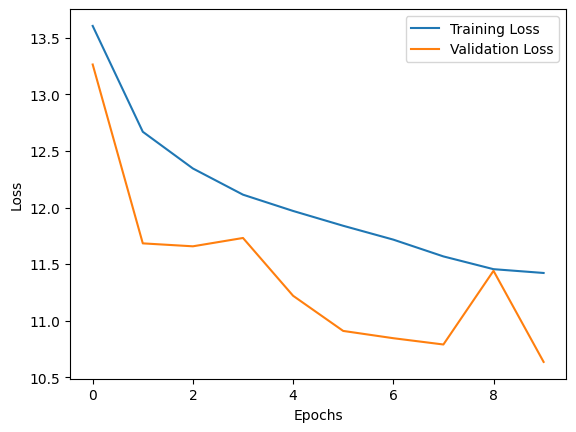

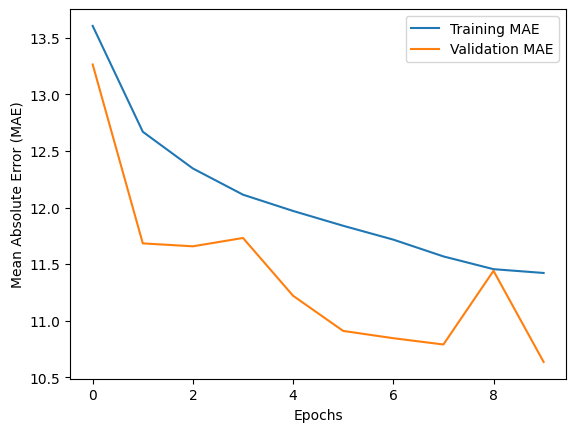

In [ ]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

